# Projet 6 : Classez des images à l'aide d'algorithmes de Deep Learning

L'objectif de ce projet est de faire de la classification d'images de chien de la base de données Stanford Dogs Dataset. On va construire un réseau de neurones convolutif (CNN) pour reconnaître la race d'un chien à partir d'une image.

## Notebook 1 : Deep Learning
* Extraction des images
* Visualisation des images
* Data Augmentation
* Split des données


Ressources utiles : 

Data Augmentation : https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

batch size : https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

split : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

tensorflow-gpu install : https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa

## Librairies utilisées

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

On utilise dans cette étude tensorflow-gpu pour bénéficier de la puissance de calcul de la carte graphique.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Extraction des images

Les images ont été extraites à l'adresse suivante : http://vision.stanford.edu/aditya86/ImageNetDogs/

Elles sont stockées dans un dossier datasets/

In [3]:
# download data from Stanfords Dogs Dataset
data_dir = tf.keras.utils.get_file(
    fname='images.tar',
    origin='http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar',
    cache_subdir='datasets',
    extract=False,
    cache_dir='./')


On change le nom des dossiers pour avoir le nom des classes

In [4]:
basedir = os.path.abspath('./datasets/Images')
for name_dir in os.listdir(basedir):
  if not os.path.isdir(os.path.join(basedir, name_dir)): # Not a directory
    continue 
  if 'n02' in name_dir: # Invalid format
    new_name = name_dir.split(sep='-', maxsplit=1)[1]
    os.rename(
        os.path.join(basedir, name_dir),
        os.path.join(basedir, new_name))
  

## Visualisation des images

On charge notre dataset dans un objet tf.data.Dataset

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./datasets/Images',
    labels='inferred')

Found 20580 files belonging to 121 classes.


In [6]:
num_classes = len(dataset.class_names)
print(f'Il y a {num_classes} classes de race de chien dans notre dataset')

Il y a 121 classes de race de chien dans notre dataset


On compte le nombre de fichier dans chaque dossier.

In [7]:
list_classes = []
list_size = []

basedir = os.path.abspath('./datasets/Images')
for name_class in os.listdir(basedir):
    class_path = os.path.join(basedir, name_class)
    list_classes.append(name_class)
    list_size.append(len(os.listdir(class_path)))

df = pd.DataFrame({'classes':list_classes, 'size':list_size})

On visualise le nombre d'images par races de chien.

<AxesSubplot:xlabel='size', ylabel='classes'>

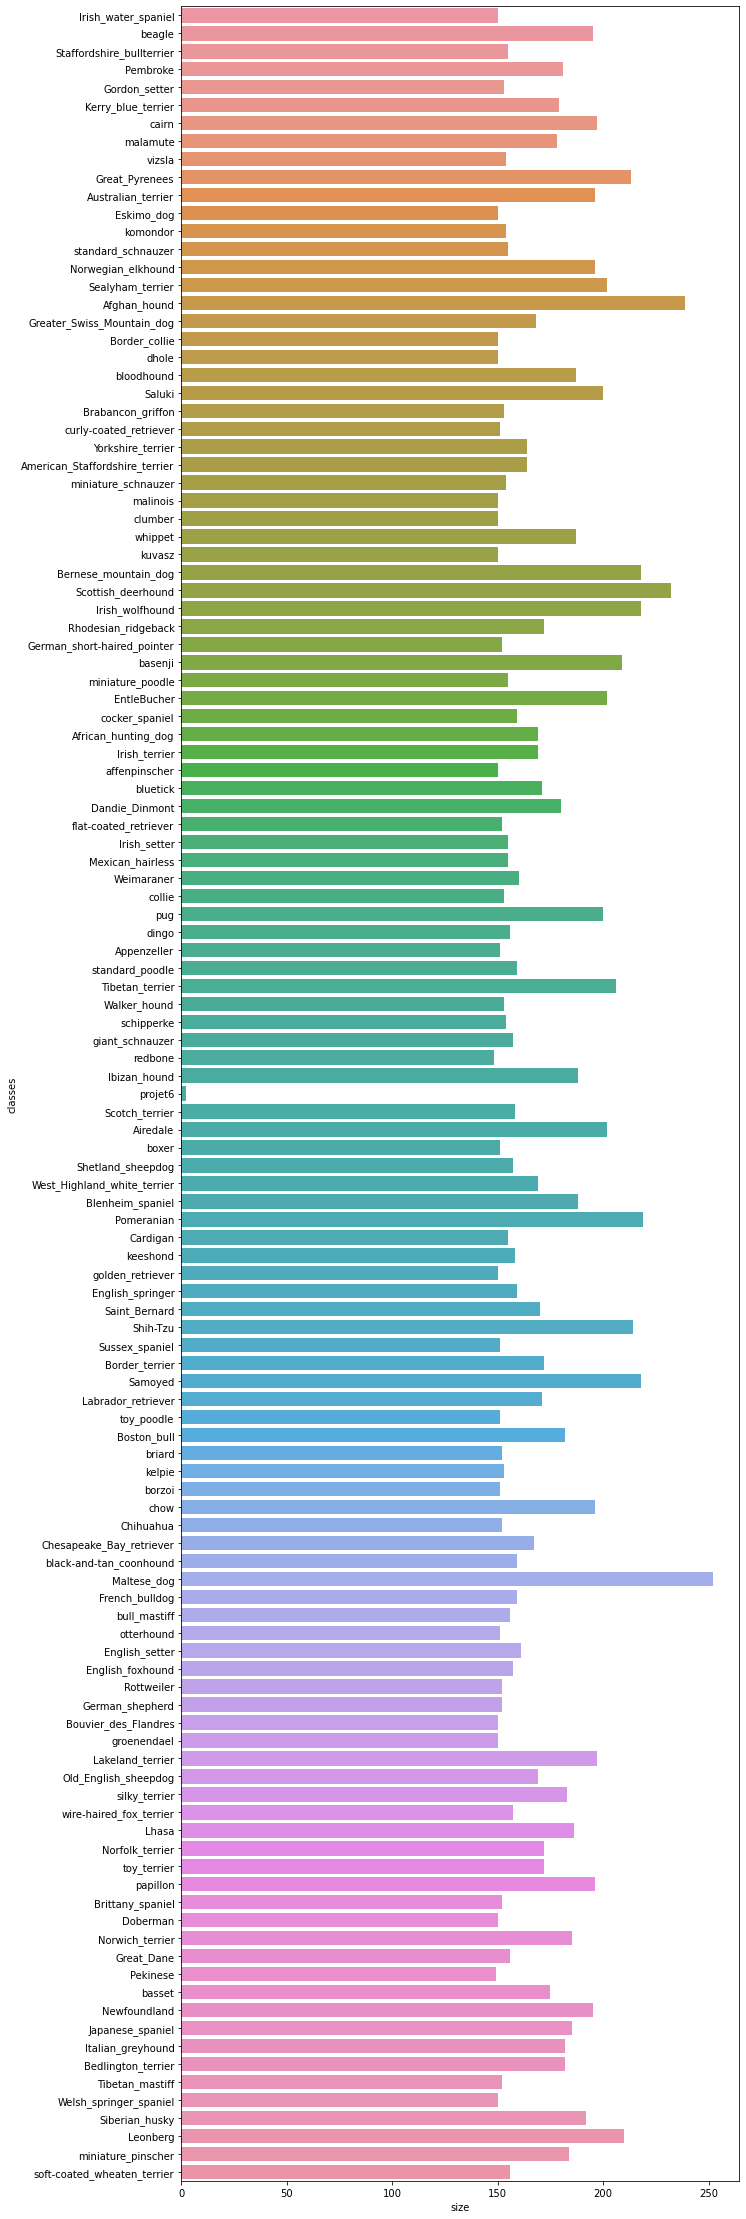

In [8]:
plt.figure(figsize=(10,40))
sns.barplot(x='size', y='classes', data=df)

Quelques images d'exemple du dataset. La méthode take d'un objet tf.data.Dataset permet d'extraire un objet tf.data.Dataset qui correspond à un batch d'images.

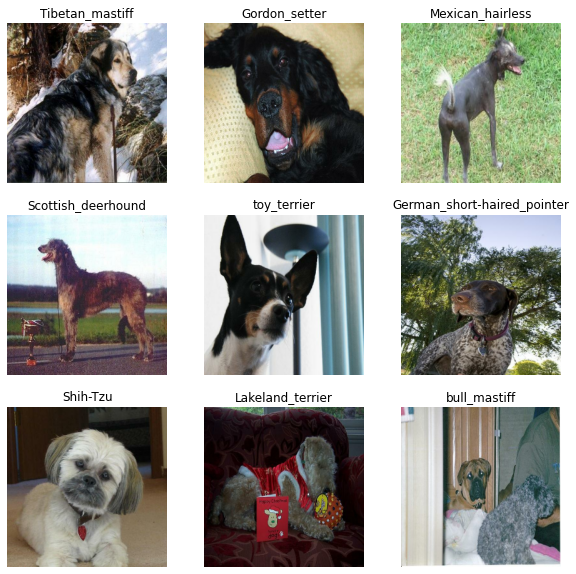

In [9]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

En Deep Learning on a besoin d'un très grand nombre de données. Il existe des techniques de Data Augmentation qui permettent d'améliorer un modèle lorsque l'on a peu de données. Cela consiste à générer des modifications aléatoires dans les images pour faire comme si on avait plus d'images. Donc on ne modifie pas le nombre d'images mais on essaie d'exploiter le plus possible les images. 

Pour cela on peut utiliser la classe ImageDataGenerator de tensorflow : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Text(0.5, 1.0, 'malamute')

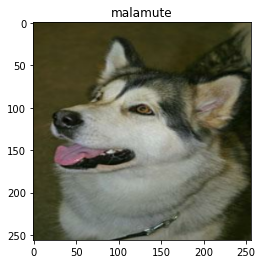

In [10]:
example, = dataset.unbatch().take(1)
image, label = example
image = image.numpy().astype("uint8")


plt.imshow(image)
plt.title(class_names[label])

In [11]:
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

On va appliquer des modifications à cette image. On définit une fonction qui prend en entrée l'image à modifier et un object ImageDataGenerator qui permet de réaliser une modification.

In [12]:
def plot(images, data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    plt.show()


Il existe plusieurs techniques pour créer de nouvelles images.

### Rotation

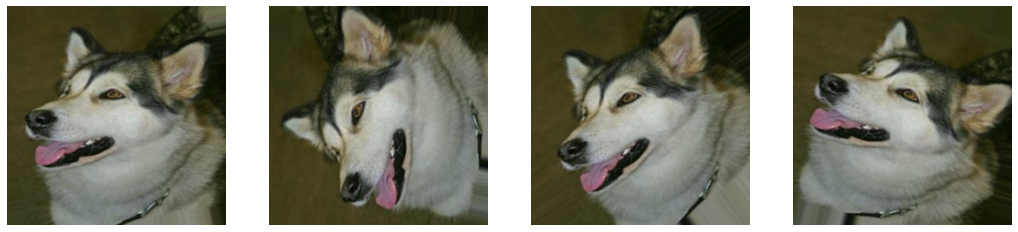

In [13]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90)
plot(images, data_generator)

### Déplacement horizontal

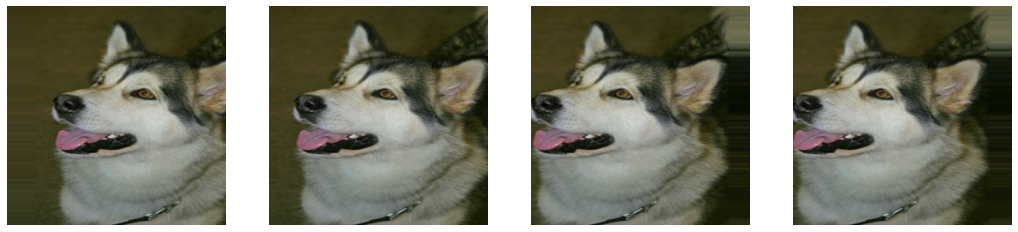

In [14]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.3)
plot(images, data_generator)

### Déplacement vertical

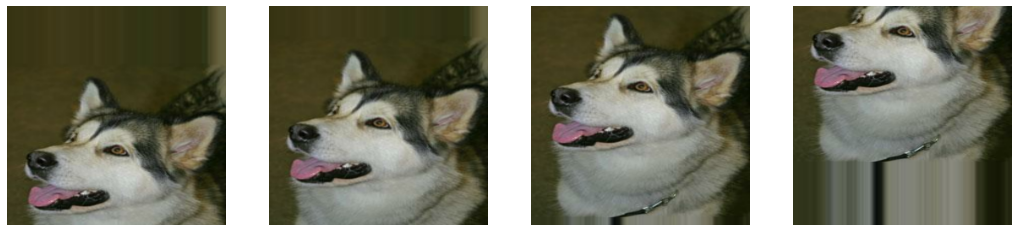

In [15]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range=0.3)
plot(images, data_generator)

### Luminosité

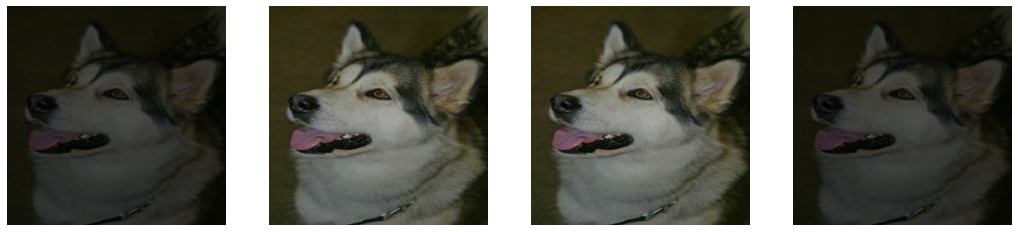

In [16]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=(0.1, 0.9))
plot(images, data_generator)

### Etirement

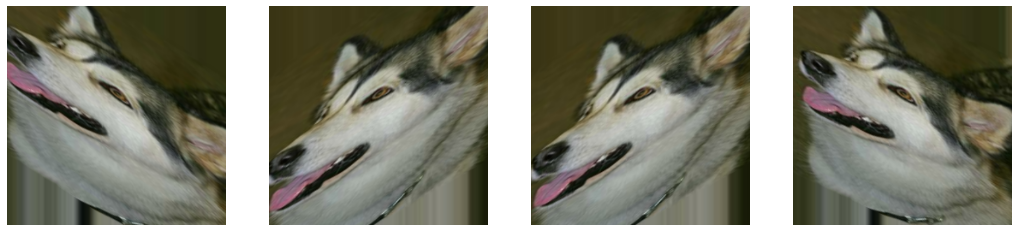

In [17]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=45.0)
plot(images, data_generator)

### Zoom

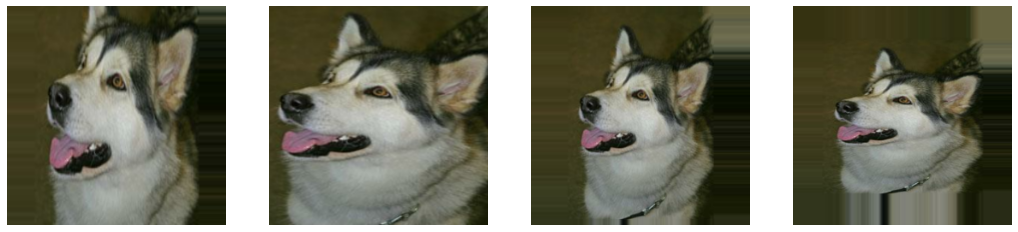

In [18]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5, 1.5])
plot(images, data_generator)

### Channel shift

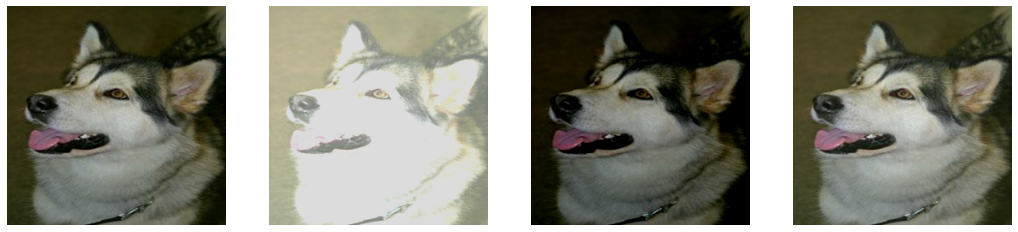

In [19]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(channel_shift_range=150.0)
plot(images, data_generator)

### Inversement horizontal

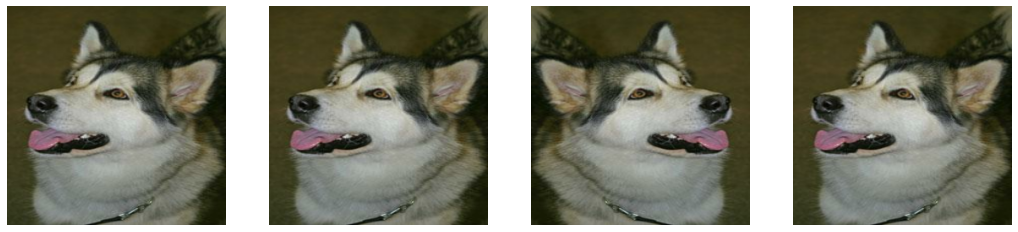

In [20]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
plot(images, data_generator)

### Inversement vertical

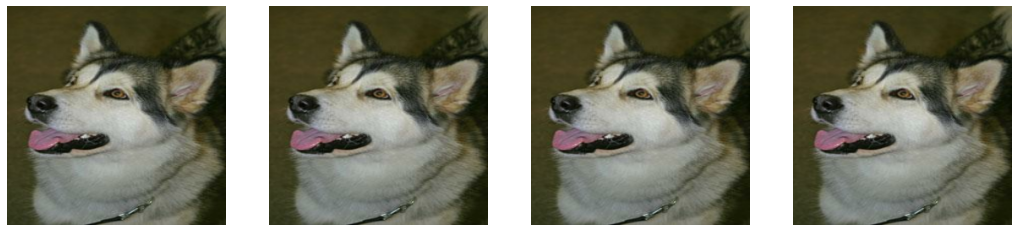

In [21]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)
plot(images, data_generator)

## Split des données

In [22]:
batch_size = 64
img_height = 160
img_width = 160
img_shape = (img_height, img_width)

### sans Data Augmentation

In [23]:
no_augmentation_kwargs = dict(
    rescale=1./255,
    validation_split=0.2)

In [24]:
train_datagen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

train_generator_no_augmentation = train_datagen_no_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 121 classes.


In [25]:
validation_datagen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_no_augmentation = validation_datagen_no_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 121 classes.


### avec Data Augmentation

In [26]:
augmentation_kwargs = dict(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.1, 0.9),
    shear_range=45.0,
    zoom_range=[0.5, 1.5],
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [27]:
train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 121 classes.


In [28]:
validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 121 classes.


## Model de base

### sans Data Augmentation

In [29]:
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator_no_augmentation.num_classes, activation='softmax')
])

In [30]:
model_base.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [31]:
steps_per_epoch = train_generator_no_augmentation.samples // train_generator_no_augmentation.batch_size
validation_steps = validation_generator_no_augmentation.samples // validation_generator_no_augmentation.batch_size

history_base = model_base.fit(
    train_generator_no_augmentation,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_no_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
257/257 [==============================] - 83s 320ms/step - loss: 4.7763 - accuracy: 0.0135 - val_loss: 4.5675 - val_accuracy: 0.0238
Epoch 2/10
257/257 [==============================] - 82s 319ms/step - loss: 4.4475 - accuracy: 0.0368 - val_loss: 4.3766 - val_accuracy: 0.0464
Epoch 3/10
257/257 [==============================] - 82s 318ms/step - loss: 4.0668 - accuracy: 0.0894 - val_loss: 4.2511 - val_accuracy: 0.0672
Epoch 4/10
257/257 [==============================] - 82s 317ms/step - loss: 3.6324 - accuracy: 0.1624 - val_loss: 4.3740 - val_accuracy: 0.0682
Epoch 5/10
257/257 [==============================] - 82s 318ms/step - loss: 3.0145 - accuracy: 0.2749 - val_loss: 4.6310 - val_accuracy: 0.0657
Epoch 6/10
257/257 [==============================] - 82s 318ms/step - loss: 2.3400 - accuracy: 0.4180 - val_loss: 5.2486 - val_accuracy: 0.0657
Epoch 7/10
257/257 [==============================] - 81s 314ms/step - loss: 1.6339 - accuracy: 0.5805 - val_loss: 6.3379 - val_ac

#### Learning curves

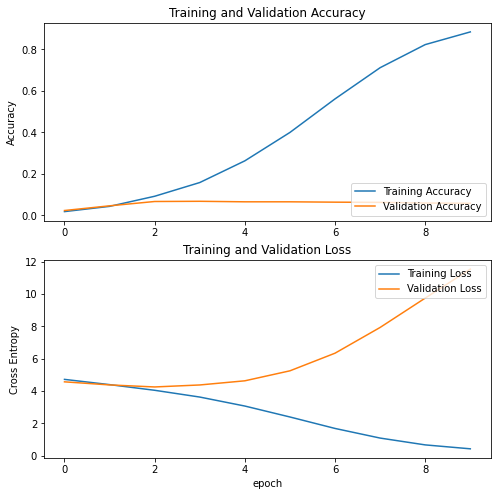

In [32]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### avec Data Augmentation

In [33]:
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator_augmentation.num_classes, activation='softmax')
])

In [34]:
model_base.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator_augmentation.samples // train_generator_augmentation.batch_size
validation_steps = validation_generator_augmentation.samples // validation_generator_augmentation.batch_size

history_base = model_base.fit(
    train_generator_augmentation,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
257/257 [==============================] - 171s 664ms/step - loss: 4.7954 - accuracy: 0.0094 - val_loss: 4.7778 - val_accuracy: 0.0154
Epoch 2/10
257/257 [==============================] - 170s 661ms/step - loss: 4.7589 - accuracy: 0.0145 - val_loss: 4.7095 - val_accuracy: 0.0154
Epoch 3/10
257/257 [==============================] - 162s 629ms/step - loss: 4.6963 - accuracy: 0.0160 - val_loss: 4.6874 - val_accuracy: 0.0166
Epoch 4/10
257/257 [==============================] - 160s 621ms/step - loss: 4.6745 - accuracy: 0.0184 - val_loss: 4.6738 - val_accuracy: 0.0188
Epoch 5/10
257/257 [==============================] - 161s 627ms/step - loss: 4.6522 - accuracy: 0.0233 - val_loss: 4.6350 - val_accuracy: 0.0238
Epoch 6/10
104/257 [===========>..................] - ETA: 1:19 - loss: 4.6333 - accuracy: 0.0204

#### Learning curves

In [ ]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()